In [1]:
from platform import python_version
print(python_version())

3.8.8


In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import pandas as pd
#from pysynphot import spectrum as S
from glob import glob
import itertools

import limbdark as ld

import scipy
from scipy.optimize import minimize
from scipy.constants import k,c,h
from scipy import integrate

from astropy import units as u
from astropy import constants as const
from astropy.constants import G,R_jup,R_sun,M_jup,M_sun,au,pc,sigma_sb

# Definition and filter settings

In [2]:
def _bb(lam,T):
    '''
    Planck's law[W/m**2/m/sr] with fixed temperature
    [input]
    T: star's effective temperature
    '''    
    B_lambda = (2*h*(np.power(c,2)) )/ (np.power(lam,5) * (np.exp(h*c/ (lam*k*T)) - 1))
    
    return B_lambda


def _bb_f(lam,T):
    '''
    Planck's law[W/m**2/Hz/sr] with fixed temperature
    [input]
    temp: star's effective temperature
    '''    
    nu = c/lam
    B_freq = 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))
    
    return B_freq



def _ABmag(temp,r_s,dist):
    '''
    AB mag calculator for Johnson B,I,R,V and Kepler
    note(210727): need to prepare the filters before running this function 
    
    [Input]
    temp:effective temperature of the star[K]
    r_s: stellar radius[R_sun]
    dist: distance from the star to the Earth[m]
    '''
    
    mags = []
    for b in bands:
        lam = filt[b][0] * 1e-10
        for i in range(len(filt[b])):
            nu = []
            ar_freq = []
            ar_bb_freq = []
            ar_median = []
            ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
            ar_bb_freq = np.empty(len(ar_freq))
            
            for j in range(len(ar_freq)):
                ar_bb_each = []
                ar_bb_each.append(_bb_f(ar_freq[j],temp))
            ar_median.append(np.median(ar_bb_each))
        nume = math.fsum(ar_median*filt[b][1]/(c/lam))
        denomi = math.fsum(filt[b][1]/(c/lam))
        # ' *1e3' means watt to erg/s 
        mag = -2.5 * np.log10(nume/denomi * (r_s*R_sun/dist)**2 * np.pi * 1e3) - 48.6
        mags.append(mag)
    return mags


#The following functions are used to check that the above functions are correct

def blackbody(temp,lam):
    '''
    Planck's law[W/m**2/m/sr][W/m**2/Hz/sr]  
    [input]
    temp: star's effective temperature
    lam: wavelength[m]
    [return]
    B_lambda:the spectral radiance of a body for wavelength
    B_freq:the spectral radiance of a body for frequency
    '''
    #frequency
    nu = c/lam
    B_lambda = 2*h*c**2 / (lam**5 * (np.exp(h*c/ (lam*k*temp)) - 1))
    B_freq = 2*h*nu**3 / (c**3 * (np.exp(h*nu/(k*temp)) - 1))
    return B_lambda, B_freq


def sb(temp):
    '''
    Stefan–Boltzmann law[W] 
    [input]
    temp: star's effective temperature
    '''
    rad = sigma_sb * temp**4
    return rad


['./Generic_Johnson.B.dat', './Generic_Johnson.I.dat', './Generic_Johnson.R.dat', './Generic_Johnson.V.dat', './Kepler_Kepler.K.dat']


Text(0.5, 0, 'wavelength[m]')

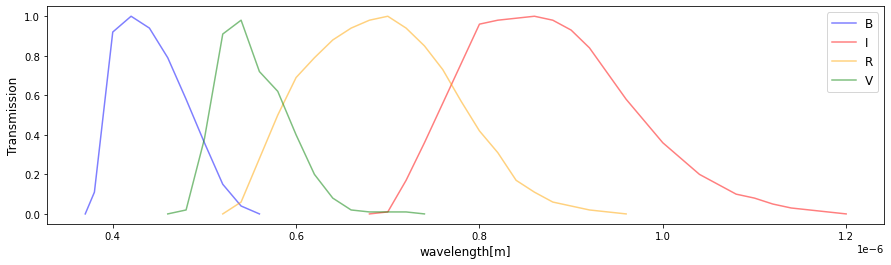

In [3]:
datadir = '.'
path    = os.path.join(datadir,'*.dat')
file_list = glob(path)
file_list = sorted(file_list)
print(file_list)

filt={}
bands = 'B,I,R,V'.split(',')
for fname,b in zip(file_list,bands):
    df=pd.read_table(fname, delimiter=' ', parse_dates=True, header=None)
    #df = df.drop('Unnamed: 0',axis=1)
    #df = df.set_index('GJD-2450000')
    filt[b] = df
filt.keys()

lam_col =  'lambda'
trans_col  =  'transmission'

colors='b,r,orange,g,black'.split(',')
fig,ax = plt.subplots(1,1,figsize=(15,4))

n=0
for b,co in zip(bands,colors):
    df = filt[b]    
    lam_nm = df[0]*1e-10
    trans = df[1]
    
    ax.plot(lam_nm, trans, label=b, color=co, alpha=0.5)
    ax.set_ylabel('Transmission', fontsize=12)
    n+=1
plt.legend(loc='upper right',fontsize=12)
plt.xlabel('wavelength[m]',fontsize=12)

# Test

## calculate the Sun's AB mag in V-band witn transmittance=100%   
Literature: -26.77mag

In [4]:
# AB mag/ the Sun/ transmission=100%/ V mag
T = 3000

B_freq_syn = lambda nu: 2*h*nu**3 / (c**2 * (np.exp(h*nu/ (k*T)) - 1))/nu
freq_syn = lambda nu: 1/nu

f_sun_syn, f_sun_syn_err = integrate.quad(B_freq_syn, c/7.4e-7, c/4.6e-6)
f_syn,f_syn_err = integrate.quad(freq_syn, c/7.4e-7, c/4.6e-6)

m = -2.5 * np.log10(f_sun_syn/f_syn * (R_sun/au)**2 * np.pi * 1e3) - 48.6
print(' V mag = {:}\n'.format(m))

 V mag = -24.63542840049576



## calculate the Sun's AB mag in B, I, R, V, Kepler mag   
[reference](https://iopscience.iop.org/article/10.3847/1538-4365/aabfdf)     
Johnson B: −26.26   
Cousins_I: −27.06    
Cousins_R: −26.97    
Johnson V: −26.77    

In [5]:
sun_mag = _ABmag(5700, 1.0, au)
print(bands)
print(sun_mag)

['B', 'I', 'R', 'V']
[<Quantity -26.71405825>, <Quantity -26.93624222>, <Quantity -27.03559216>, <Quantity -26.99922199>]


## Various stars

## R=2R_sun, T=3000K, distance=145pc

In [6]:

dmtau_mag = _ABmag(3000, 2.0, 145*pc)
print(dmtau_mag)

[<Quantity 13.49978757>, <Quantity 11.09915377>, <Quantity 11.45686821>, <Quantity 12.19964489>]


# Grid model

In [7]:
class Mesh2D:
    def __init__(self, xrange, yrange, n):
        self.n = n
        self.x_min = xrange[0]
        self.x_max = xrange[1]
        self.y_min = yrange[0]
        self.y_max = yrange[1]
        self.x = np.linspace(xrange[0], xrange[1], n)
        self.y = np.linspace(yrange[0], yrange[1], n)
        self.X, self.Y = np.meshgrid(self.x, self.y)
        
def _g(x, y, us, I_mean):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(x**2+y**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    
    #I_mu[x<xp] = I_mu[x<xp] * 0.8
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _g_ratio(y, z, us, I_mean, ysmin, ysmax, zsmin, zsmax):
    #mu = cos(theta)
    u1,u2 = us

    mu = np.sqrt(1-(y**2+z**2))
    I_mu = (1 - u1*(1-mu) - u2*(1-mu)**2) * I_mean
    
    I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] = I_mu[(y>ysmin)&(y<ysmax)&(z>zsmin)&(z<zsmax)] * 0.2
    
    I_mu[np.isnan(I_mu)] = 0.
    return I_mu

def _ldc(ld_params, band, law='quadratic'):
    '''
    calculate limb-darkening coefficients
    
    [Input]
    ld_params :list of the parameters to calculate LDCs. [teff, uteff, logg, ulogg, feh, ufeh]
    band: filter name (ex. 'V' 'r*')
    '''
    teff, uteff, logg, ulogg, feh, ufeh = ld_params
    ldc_list     = []
    ldc_err_list = []
    ldp = []
    
    ldc = ld.claret(band, teff, uteff, logg, ulogg, feh, ufeh, n=int(1e4), law=law)
    ldp.append(ldc)
    #u1,u2
    ldc_list=[ldc[0],ldc[2]] #take first and third element of ldc 
    #uncertainties
    ldc_err_list=[ldc[1],ldc[3]] #take second and fourth element of ldc
    
    return ldc_list

def _band_intensity(temp, filt):
    '''
    calculate mean intensity
    ref: Bessell(2011) eq.(A12)
    
    [Input]
    temp: effective temperature of the star[K]
    filt: filter profile downloaded from SVO filter profile
    '''
    lam = filt[0] * 1e-10
    bb_freq_med = []
    
    for i in range(len(filt)):
        nu = []
        ar_freq = []
        ar_bb_freq = []
        ar_freq = np.linspace(lam[i]-100e-10, lam[i]+100e-10, 10)
        ar_bb_freq = np.empty(len(ar_freq))
        for j in range(len(ar_freq)):
            ar_bb = []
            ar_bb = _bb_f(ar_freq[j],temp)
        bb_freq_med = np.median(ar_bb)

    nume = math.fsum(bb_freq_med*filt[1]/(c/lam))
    denomi = math.fsum(filt[1]/(c/lam))
    mean_intensity = nume/denomi
    
    return mean_intensity

## test with a solor like star (d=1au,R_s=R_sun)

<ipython-input-7-3a9401dc80d7>:16: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(x**2+y**2))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


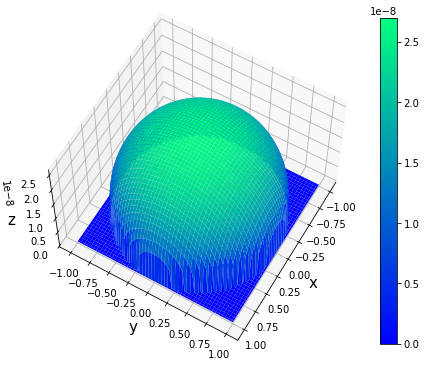

In [8]:
params = [5711, 90, 4.470, 0.054, -0.01, 0.14]
ldcs = _ldc(params, 'B')
I_mean = _band_intensity(5711,filt['B'])
ngrid = 100

m = Mesh2D([-1,1], [-1, 1], ngrid)
Z = _g(m.X, m.Y, ldcs, I_mean)
print(Z)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Z, cmap = "winter", vmin=0, vmax=2.7e-8)
fig.colorbar(p)


plt.show()

In [9]:
sum_intensity_x = []
for i in range(len(Z)):
    sum_intensity_x.append(math.fsum(Z[i]))
sum_intensity = math.fsum(sum_intensity_x)
sun_test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(R_sun/au)) + 1)
-2.5 * np.log10(sun_test_flux*1e3)- 48.6

-26.128266634828744

## test with Trappist1

<ipython-input-7-3a9401dc80d7>:16: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(x**2+y**2))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


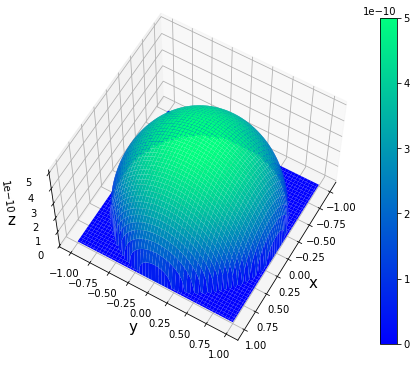

In [10]:
t_trappist = 2550
d_trappist = 12.4 #pc
rs_trappist = 0.12 #R_s
params = [t_trappist, 55, 5.2759, 0.07, 0.04, 0.08]
ldcs = _ldc(params, 'V')
I_mean = _band_intensity(t_trappist,filt['V'])
ngrid = 100

m = Mesh2D([-1,1], [-1, 1], ngrid)
Z = _g(m.X, m.Y, ldcs, I_mean)
print(Z)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Z, cmap = "winter", vmin=0, vmax=5e-10)
fig.colorbar(p)


plt.show()

In [11]:
sum_intensity_x = []
for i in range(len(Z)):
    sum_intensity_x.append(math.fsum(Z[i]))
sum_intensity = math.fsum(sum_intensity_x)
sun_test_flux = np.pi * sum_intensity/(ngrid**2) * (math.sin(math.asin(rs_trappist*R_sun/(d_trappist*pc))))**2
-2.5 * np.log10(sun_test_flux*1e3)- 48.6

14.921094964431973

# rotaion

In [12]:
def _Rx(theta):
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, math.cos(theta),-math.sin(theta)],
                   [ 0, math.sin(theta), math.cos(theta)]])
  
def _Ry(theta):
    return np.matrix([[ math.cos(theta), 0, math.sin(theta)],
                   [ 0           , 1, 0           ],
                   [-math.sin(theta), 0, math.cos(theta)]])
  
def _Rz(theta):
    return np.matrix([[ math.cos(theta), -math.sin(theta), 0 ],
                   [ math.sin(theta), math.cos(theta) , 0 ],
                   [ 0           , 0            , 1 ]])

def _Ru(inc, phi):
    ux = math.cos(inc)
    uy = 0
    uz = math.sin(inc)
    
    alpha = 1 - math.cos(phi)
    beta  = math.sin(phi)
    
    return np.matrix([[alpha*ux**2 + math.cos(phi), alpha*ux*uy - beta*uz,      alpha*ux*uz + beta*uy],
                               [alpha*uy*ux + beta*uz,     alpha*uy**2 + math.cos(phi), alpha*uy*uz - beta*ux],
                               [alpha*uz*ux - beta*uy,      alpha*uz*uy + beta*ux,     alpha*uz**2+math.cos(phi)]])

In [13]:
inc = math.pi/2 
phi = math.pi/2 - inc
theta = 0 # long
psi = 0  # -lat
phase = np.arange(0,2*math.pi, math.pi/6)

spot_0 = np.matrix([[1],[0],[0]])
R = _Ry(psi) * _Rz(theta) * _Ry(phi)

coord = []

for i in range(len(phase)):
    coord.append(_Ru(inc, phase[i]) * (R * spot_0))    


In [18]:
nrho = 10
radius = 0.1
inc = math.pi/2 - math.pi/6
phi = math.pi/2 - inc
theta = 0 # long
psi = 0  # -lat
phase = np.arange(0,2*math.pi, math.pi/6)
pos_ang =  np.linspace(0, 2 * np.pi, nrho)

spot_origin = np.array([[1],[0],[0]])
R = _Ry(psi) * _Rz(theta) * _Ry(phi)


coord_all = []
coord_min = []
coord_max = []
for i in range(len(phase)):

    ys        = [[] for _ in range(nrho)] 
    zs        = [[] for _ in range(nrho)] 
    spot0   = [[] for _ in range(nrho)] #matrix
    coord0 =  [[] for _ in range(nrho)] #matrix after rotation

    for j in range(nrho):
        x0 = np.sqrt(1 - radius**2)
        zs[j] = radius * np.sin(pos_ang[j])
        ys[j] = radius * np.cos(pos_ang[j])

        spot0[j] = np.array([[x0],[ys[j]],[zs[j]]])
        coord0[j] = (_Ru(inc, phase[i]) * (R * spot0[j]))
        
    coord_all.append(coord0)
    coord_max.append(np.amax(coord_all[i], axis=0))
    coord_min.append(np.amin(coord_all[i], axis=0))
    
    


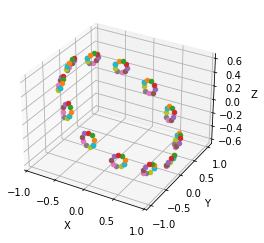

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
for i in range(len(coord_all)):
    for j in range(len(coord_all[i])):

        ax.scatter(coord_all[i][j][0], coord_all[i][j][1], coord_all[i][j][2], marker='o')

plt.show()

coord_trans = []
for i in range(len(coord)):
    trans = []
    trans = coord[i].flatten().flatten()
    print(trans)
    coord_trans.append(list(itertools.chain.from_iterable(trans)))

coord_trans

1. how to create dataframe from the matrix   
2. how to find out which grid a sunspot matches   
3. create large spot -- how to calculate minimun and maximum position of the spot   
4. change the intensity of a specific grid  

<ipython-input-7-3a9401dc80d7>:28: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


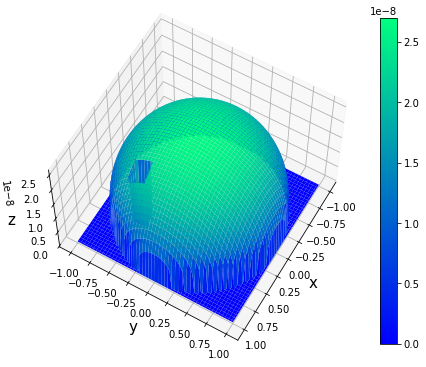

-26.119331897805154

In [21]:
params = [5711, 90, 4.470, 0.054, -0.01, 0.14]
ldcs = _ldc(params, 'B')
I_mean = _band_intensity(5711,filt['B'])
ngrid = 100

i = 1
m = Mesh2D([-1,1], [-1, 1], ngrid)
Z = _g_ratio(m.X, m.Y, ldcs, I_mean, coord_min[i][1],coord_max[i][1], coord_min[i][2], coord_max[i][2])
print(Z)

fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Z, cmap = "winter", vmin=0, vmax=2.7e-8)
fig.colorbar(p)

plt.show()

sum_intensity_x = []
for i in range(len(Z)):
    sum_intensity_x.append(math.fsum(Z[i]))
sum_intensity = math.fsum(sum_intensity_x)
sun_test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(R_sun/au)) + 1)
-2.5 * np.log10(sun_test_flux*1e3)- 48.6

In [22]:
params = [5711, 90, 4.470, 0.054, -0.01, 0.14]
ldcs = _ldc(params, 'B')
I_mean = _band_intensity(5711,filt['B'])
ngrid = 100

Zs = [[] for _ in range(len(phase))] 
m = Mesh2D([-1,1], [-1, 1], ngrid)
for i in range(len(phase)):
    Zs[i] = _g_ratio(m.X, m.Y, ldcs, I_mean, coord_min[i][1],coord_max[i][1], coord_min[i][2], coord_max[i][2])


sum_intensity_x = [[] for _ in range(len(phase))] 
sum_intensity   = [[] for _ in range(len(phase))] 
sun_test_flux   = [[] for _ in range(len(phase))] 
spot_mag        = [[] for _ in range(len(phase))] 
for i in range(len(Zs)):
    for j in range(len(Zs[i])):
        sum_intensity_x[i].append(math.fsum(Zs[i][j]))
    sum_intensity = math.fsum(sum_intensity_x[i])
    sun_test_flux = np.pi * sum_intensity/(ngrid**2) * 1/2 * (-math.cos(2*math.asin(R_sun/au)) + 1)
    spot_mag[i].append(-2.5 * np.log10(sun_test_flux*1e3)- 48.6)

<ipython-input-7-3a9401dc80d7>:28: RuntimeWarning: invalid value encountered in sqrt
  mu = np.sqrt(1-(y**2+z**2))


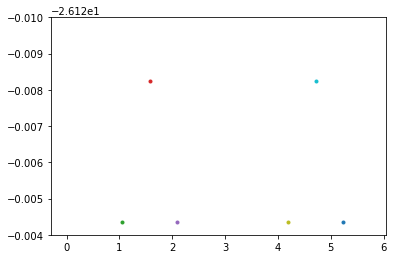

In [23]:
for i in range(len(phase)):
    plt.plot(phase[i],spot_mag[i],'.')
    plt.ylim(-26.124, -26.13)


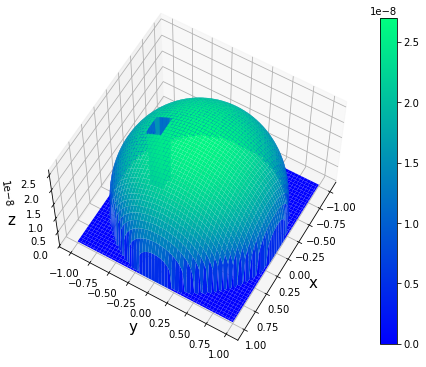

In [24]:
i = 0
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Zs[i], cmap = "winter", vmin=0, vmax=2.7e-8)
fig.colorbar(p)

plt.show()

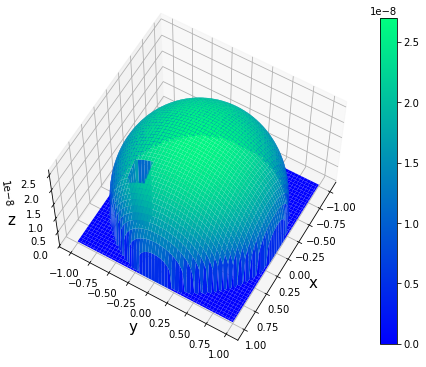

In [27]:
i = 1
fig = plt.figure(figsize = (8, 6))
ax = fig.add_subplot(111, projection="3d")

# 3DAxes
ax.set_xlabel("x", size = 15)
ax.set_ylabel("y", size = 15)
ax.set_zlabel("z", size = 15)
ax.view_init(60, 30)

p = ax.plot_surface(m.X, m.Y, Zs[i], cmap = "winter", vmin=0, vmax=2.7e-8)
fig.colorbar(p)

plt.show()